
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## STORM database. Extraction of TC affecting the study area and MDA selection

input required:
   * The 10,000 year TC STORM dataset https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d
   * The historical TCs from Ibtracks ***notebook 05***
    
in this notebook:
   * read STORM database
   * plot historical and synthetic TCs affecting the study site
   * parameterization of TCs
   * MDA selection and plotting

In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import glob
import pandas as pd
import matplotlib.pyplot as plt

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.io.matlab import ReadNakajoMats_sara
from teslakit.database import Database
from teslakit.storms import Extract_Circle_STORM
from teslakit.mda import MaxDiss_Simplified_NoThreshold
from teslakit.plotting.storms import Plot_TCs_STORMSbase_Tracks, Plot_TCs_Params_STORM_MDAvsSIM, \
    Plot_TCs_Params_HISTvsSIM, Plot_TCs_Params_HISTvsSIM_histogram, Plot_TCs_Tracks_Category


## Database and Site parameters

In [19]:

p_data = r'/Users/anacrueda/Documents/Proyectos/TESLA/data' 
p_data_temp = r'/Users/anacrueda/Documents/Data/STORMs/data'

db = Database(p_data)

# set site
db.SetSite('MAJURO')

# choose the basin. STORM consider independent basins, therefore the synthetic TCs wont cross from one basin to the other.
basins = ['WP'] # EP: Eastern Pacific, NA: North Atlantic, NI: North Indian, 
             # SI: South Indian, SP: South Pacific, WP: Western Pacific

# wave point longitude and latitude 
pnt_lon = 171.18
pnt_lat = 7.11

# radius for TCs selection (º)
r1 = 14
r2 = 4


## STORM database

In [13]:
# load data and set parameters

# TODO : añadir basin SP
# read STORM database
path = os.path.join(p_data_temp, "STORM_DATA_IBTRACS_{}*.txt".format([basin for basin in basins]))
file_list = sorted(glob.glob(path))

tc_list = []
cont = 0
for file in file_list:
    df = pd.read_table(file,
                       sep = ',',
                       header = None,
                       names=('year', 'month', 'storm', 'TimeStep', 'Basin', 'lat', 'lon', 'pressure_min','windspeed_max','rmax','cat','land','dist_land'),
                       dtype={'year': np.float64,
                              'month': np.float64,
                              'storm': np.int64,
                              'TimeStep': np.int64,
                              'basin': np.int64,
                              'lat': np.float64,
                              'lon': np.float64,
                              'pressure_min': np.float64,
                              'windspeed_max': np.float64,
                              'rmax': np.float64,
                              'cat': np.int64,
                              'land': np.float64,
                              'dist_land': np.float64})

    #modify storm column to know how many ciclones per simulation
    for i in df['year'].unique():
        if i == 0: continue
        late_storm = np.nanmax(df.loc[df.year == i-1, ['storm']])
        #print(late_storm)
        df.loc[df.year == i, ['storm']] = df.loc[df.year == i, ['storm']] + late_storm

    if cont > 0:
        last_storm = storms[-1]
        #print('last_storm')
        #print(last_storm)
        df['storm'] = df['storm']+last_storm
    df.set_index('storm', inplace=True)
    # store DataFrame in list
    tc_list.append(df)
    storms = df.index.tolist()
    cont = cont + 1

tc_list = pd.concat(tc_list)

tc_storms = tc_list.to_xarray()

print(tc_storms)

['/Users/anacrueda/Documents/Data/STORMs/data/STORM_DATA_IBTRACS_WP*.txt', '/Users/anacrueda/Documents/Data/STORMs/data/STORM_DATA_IBTRACS_SP*.txt']


TypeError: expected str, bytes or os.PathLike object, not list

In [4]:
# Get STORMS TCs at the study area
# dictionary with needed variable names
d_vns = {
    'longitude':'lon',
    'latitude':'lat',
    'time': 'TimeStep',
    'pressure':'pressure_min',
    'radius':'rmax',
    'mwinds': 'windspeed_max',
}

# Extract STORMS TCs inside r2
TCs_r2_sim_tracks, TCs_r2_sim_params = Extract_Circle_STORM(tc_storms, pnt_lon, pnt_lat, r2, d_vns)
TCs_r2_sim_tracks = TCs_r2_sim_tracks.isel(storm = slice(0,len(TCs_r2_sim_params.storm)))

#print(TCs_r2_sim_tracks)


(215262, 429)


NameError: name 'TCs_r1_sim_tracks' is not defined

In [5]:
#remove nans
#TCs_r1_sim_tracks = TCs_r1_sim_tracks.isel(storm = slice(0,len(TCs_r1_sim_params.storm)))
TCs_r2_sim_tracks = TCs_r2_sim_tracks.isel(storm = slice(0,len(TCs_r2_sim_params.storm)))

# Store STORMS TCs parameters
#db.Save_TCs_r1_sim(TCs_r1_sim_tracks, TCs_r1_sim_params)
db.Save_TCs_r2_sim(TCs_r2_sim_tracks, TCs_r2_sim_params)

In [56]:
# load tcs
TCs_r2_sim_tracks, TCs_r2_sim_params = db.Load_TCs_r2_sim()
print(TCs_r2_sim_tracks)

TCs_r2_hist_tracks, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2
print(TCs_r2_hist_tracks)

<xarray.Dataset>
Dimensions:   (storm: 1711, time: 429)
Coordinates:
  * storm     (storm) int64 0 1 2 3 4 5 6 ... 1704 1705 1706 1707 1708 1709 1710
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 421 422 423 424 425 426 427 428
Data variables:
    pressure  (storm, time) float64 ...
    velocity  (storm, time) float64 ...
    wind      (storm, time) float64 ...
    radius    (storm, time) float64 ...
    lon       (storm, time) float64 ...
    lat       (storm, time) float64 ...
Attributes:
    source:   teslakit_v0.9.1
<xarray.Dataset>
Dimensions:          (center: 26, storm: 39, time: 137)
Coordinates:
  * storm            (storm) int64 1660 1893 2067 2072 ... 6223 6259 7185 7207
Dimensions without coordinates: center, time
Data variables:
    storm_sn         (storm) |S13 ...
    name             (storm) |S57 ...
    numObs           (storm) int16 ...
    season           (storm) int16 ...
    track_type       (storm) int8 ...
    genesis_basin    (storm) int8 ...
    num_basins 

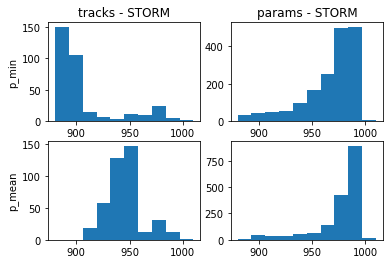

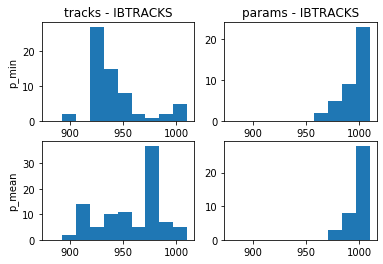

In [60]:
fig, [(ax0, ax1), (ax2, ax3)] = plt.subplots(nrows = 2, ncols = 2)
ax0.hist(TCs_r2_sim_tracks.pressure.min(dim='storm'),range=[880,1010])
ax0.set_title('tracks - STORM')
ax0.set_ylabel('p_min')

ax1.hist(TCs_r2_sim_params.pressure_min,range=[880,1010])
ax1.set_title('params - STORM')

ax2.hist(TCs_r2_sim_tracks.pressure.mean(dim='storm'),range=[880,1010])
ax2.set_ylabel('p_mean') 

ax3.hist(TCs_r2_sim_params.pressure_mean,range=[880,1010])
plt.show()


fig, [(ax0, ax1), (ax2, ax3)] = plt.subplots(nrows = 2, ncols = 2)
ax0.hist(TCs_r2_hist_tracks.pres_wmo.min(dim='storm'),range=[880,1010])
ax0.set_title('tracks - IBTRACKS')
ax0.set_ylabel('p_min')

ax1.hist(TCs_r2_hist_params.pressure_min,range=[880,1010])
ax1.set_title('params - IBTRACKS')

ax2.hist(TCs_r2_hist_tracks.pres_wmo.mean(dim='storm'),range=[880,1010])
ax2.set_ylabel('p_mean') 

ax3.hist(TCs_r2_hist_params.pressure_mean,range=[880,1010])
plt.show()


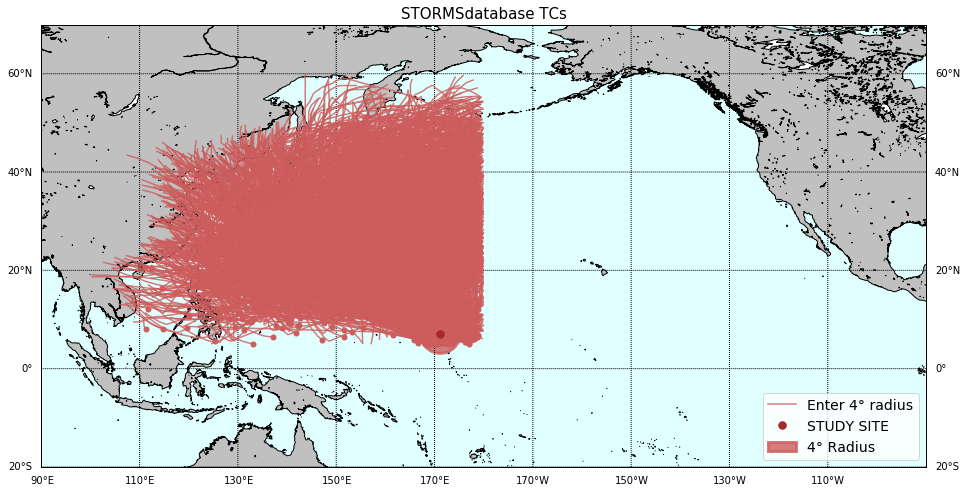

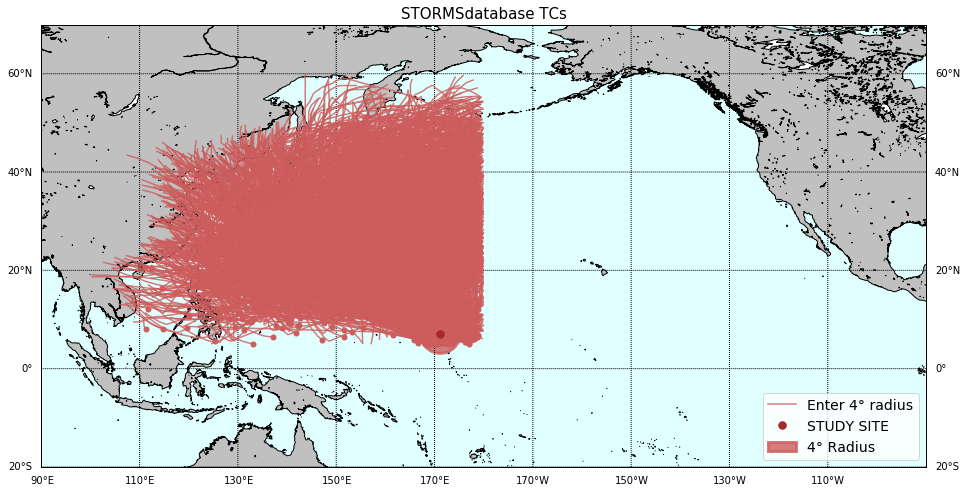

In [6]:
# Plot storm tracks world map (requires basemap)
lon1, lon2 = 90, 270
lat1, lat2 = -20, 70

Plot_TCs_STORMSbase_Tracks(
    TCs_r2_sim_tracks,
    lon1, lon2, lat1, lat2,
    pnt_lon, pnt_lat,  r2,
)


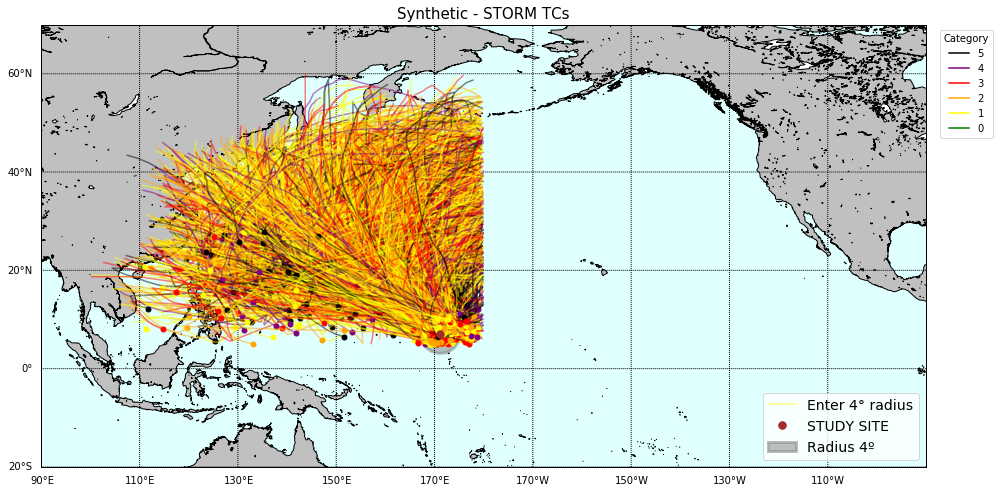

In [7]:
# Plot storm tracks category world map (requires basemap)
# r2
Plot_TCs_Tracks_Category(
    TCs_r2_sim_tracks, 
    TCs_r2_sim_params.category,
    lon1, lon2, lat1, lat2,
    pnt_lon, pnt_lat, r2, d_vns, 'Synthetic - STORM'
);



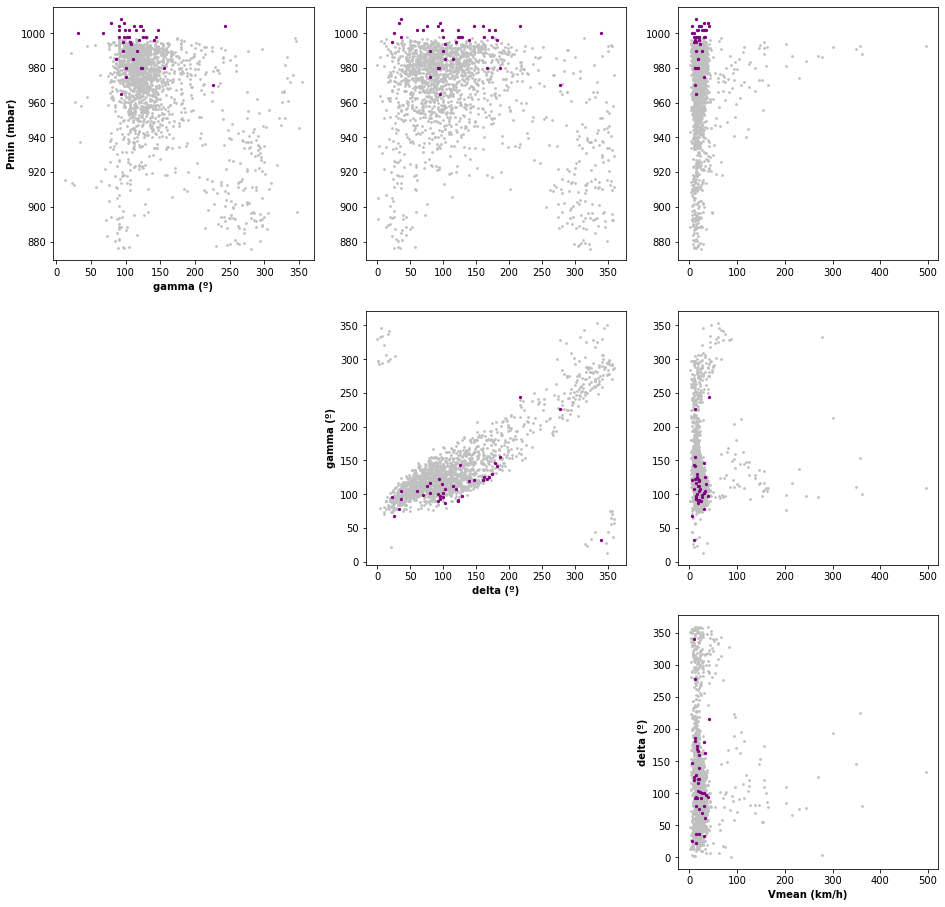

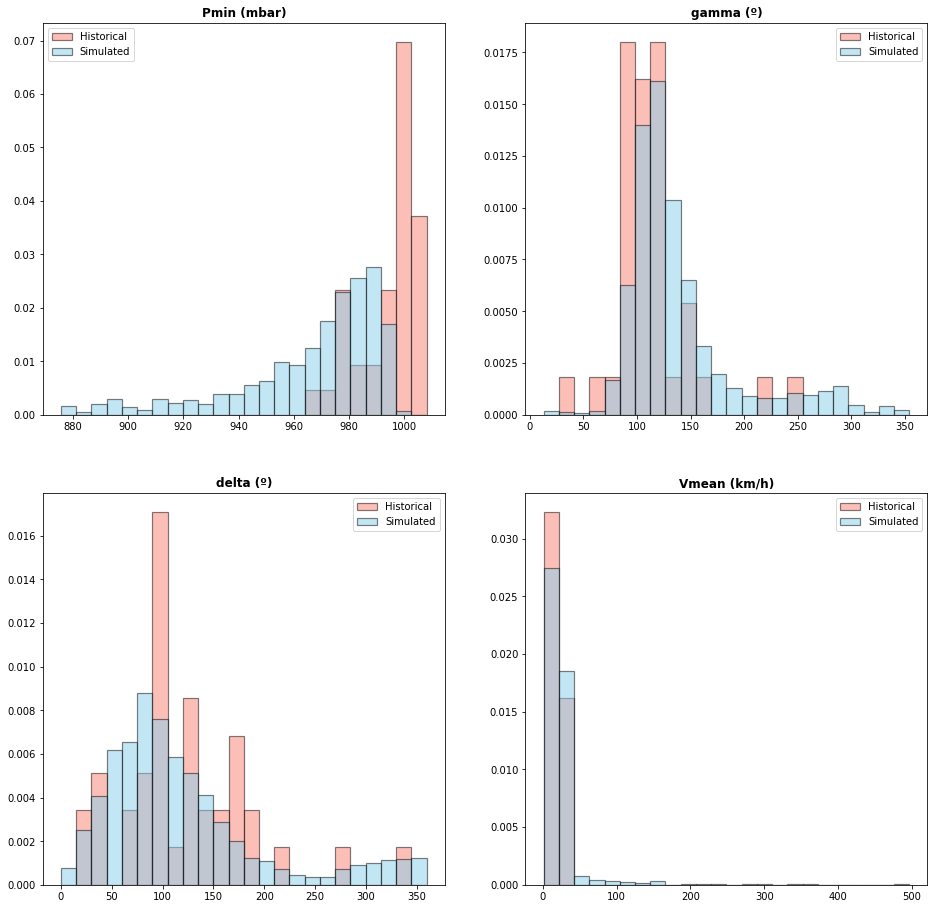

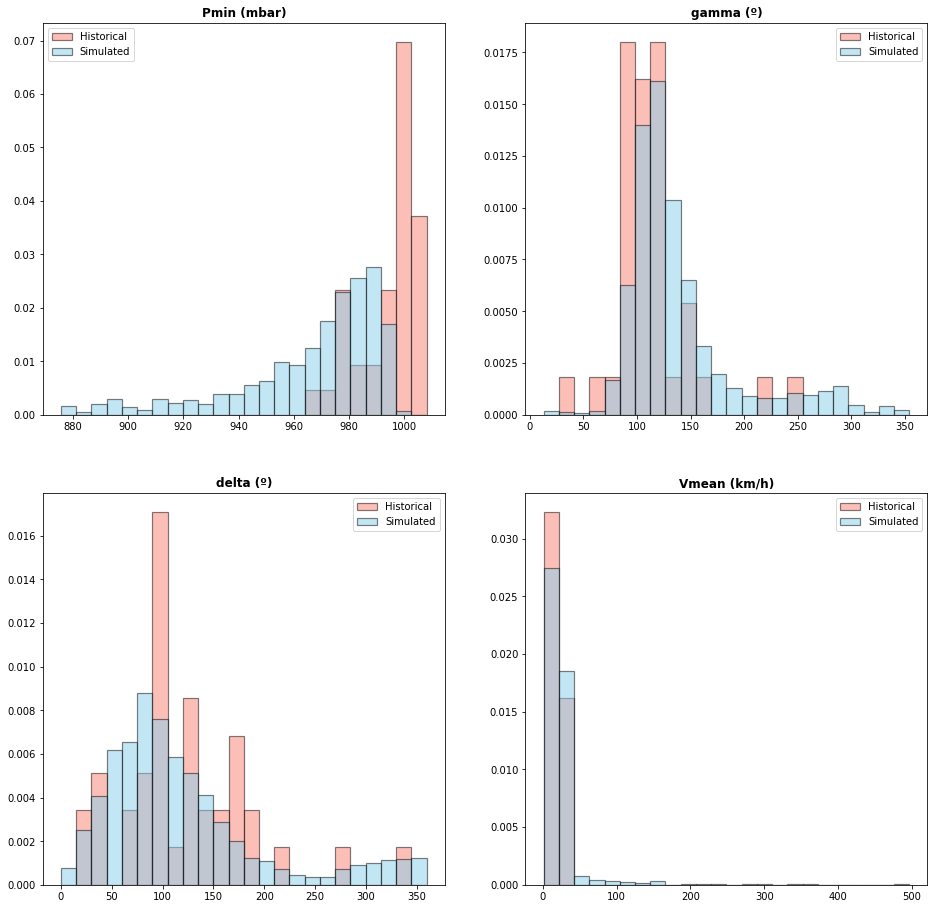

In [8]:
## check STORMs TCs vs. historical

#TCs_r2_sim_params = db.Load_TCs_r2_sim_params()

# Historical vs STORM parameters:
_, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2

# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params)

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params)



In [9]:
print(np.min(TCs_r2_sim_tracks.pressure[:]))
print(TCs_r2_hist_params)
print(np.max(TCs_r2_hist_params.pressure_min))

<xarray.DataArray 'pressure' ()>
array(853.1)
<xarray.Dataset>
Dimensions:        (storm: 39)
Coordinates:
  * storm          (storm) int64 1660 1893 2067 2072 ... 6223 6259 7185 7207
Data variables:
    pressure_min   (storm) float32 970.0 996.0 990.0 980.0 ... 998.0 996.0 998.0
    pressure_mean  (storm) float32 ...
    velocity_mean  (storm) float64 12.89 11.91 26.07 19.59 ... 30.85 20.39 10.57
    gamma          (storm) float64 225.8 141.5 95.69 123.2 ... 102.4 119.3 143.4
    delta          (storm) float64 277.5 182.2 99.55 166.3 ... 100.3 139.3 126.0
    category       (storm) int64 ...
    dmin_date      (storm) datetime64[ns] ...
    last_date      (storm) datetime64[ns] ...
    index_in       (storm) int64 ...
    index_out      (storm) int64 ...
Attributes:
    point_lon:  171.18
    point_lat:  7.11
    point_r:    4
    source:     teslakit_v0.9.1
<xarray.DataArray 'pressure_min' ()>
array(1008., dtype=float32)


## MDA selection


MaxDiss waves parameters: 1711 --> 400

   MDA centroids: 400/400

<xarray.Dataset>
Dimensions:        (storm: 400)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    pressure_mean  (storm) float64 1e+03 884.2 975.9 935.0 ... 906.8 993.1 992.8
    pressure_min   (storm) float64 995.4 877.7 953.7 921.9 ... 887.7 991.1 990.0
    velocity_mean  (storm) float64 61.88 18.69 18.72 14.11 ... 15.26 67.43 19.03
    mean_radius    (storm) float64 55.39 18.89 146.2 27.78 ... 23.21 93.43 182.0
    winds_mean     (storm) float64 13.75 64.92 28.65 47.8 ... 57.62 19.39 19.95
    delta          (storm) float64 6.011 305.4 184.3 10.26 ... 312.3 145.4 111.9
    gamma          (storm) float64 346.1 231.0 166.3 69.97 ... 263.5 158.8 158.5


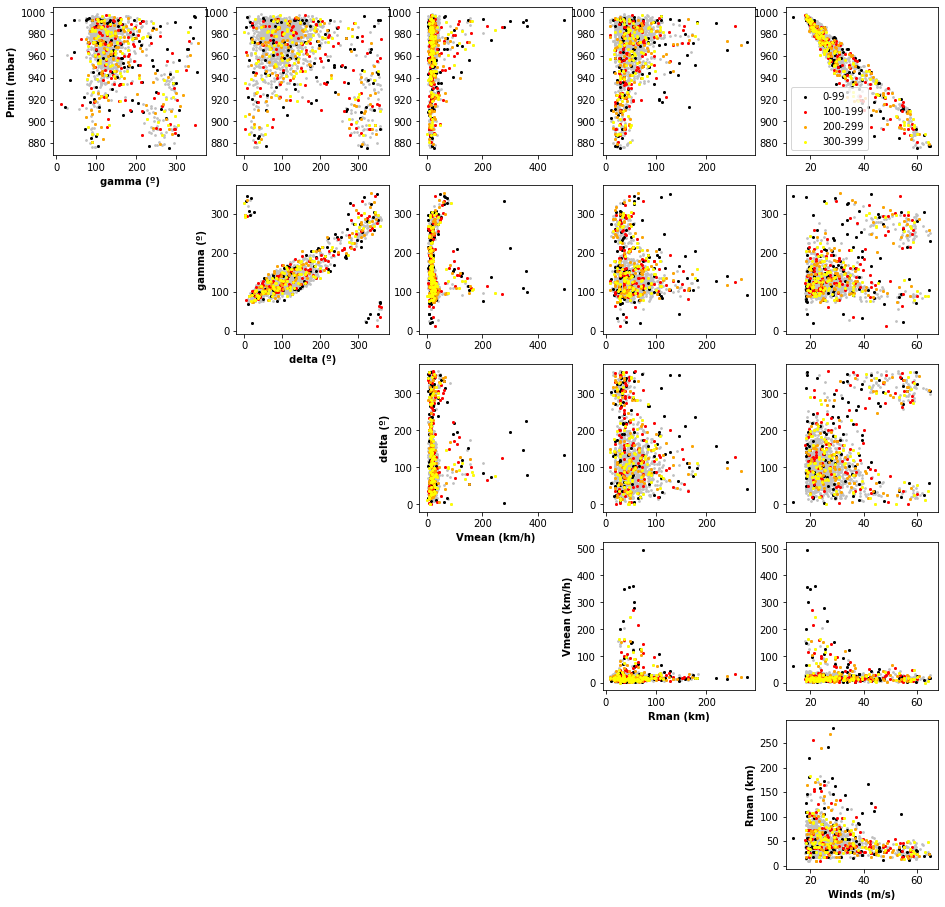

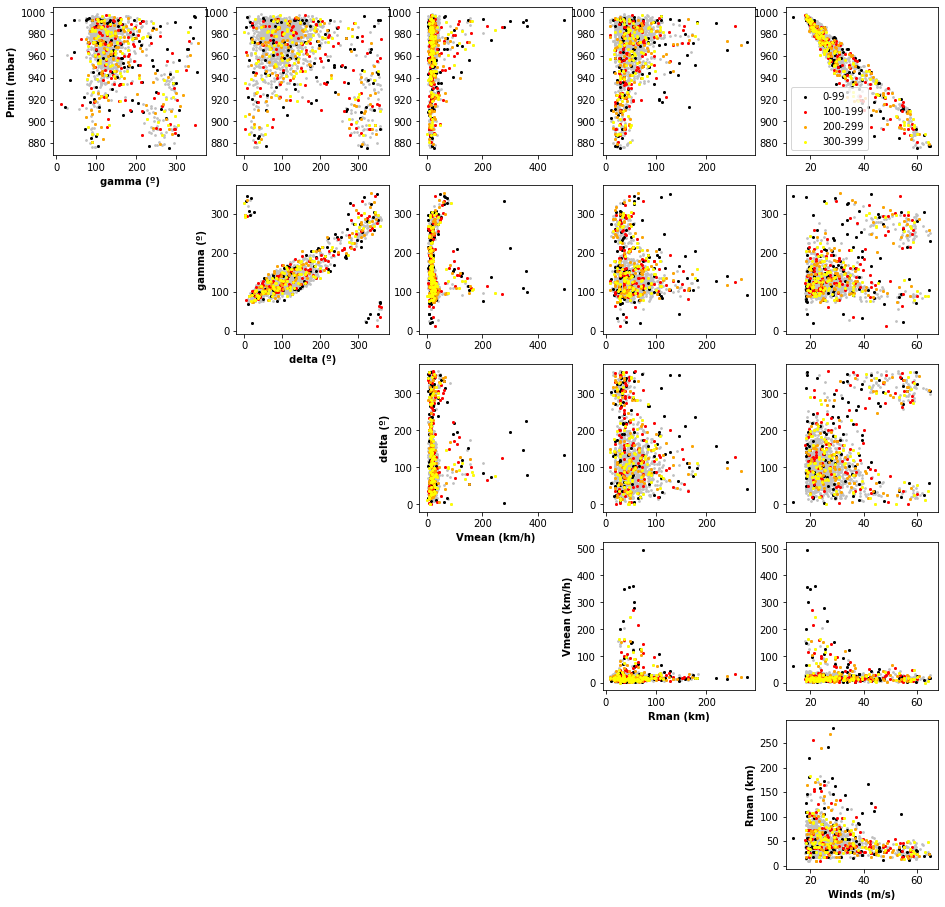

In [10]:

## MDA selection

# --------------------------------------
# MaxDiss classification

# MDA number of cases
num_sel_mda = 400

# get simulated parameters
pmean_s = TCs_r2_sim_params.pressure_mean.values[:]
pmin_s = TCs_r2_sim_params.pressure_min.values[:]
gamma_s = TCs_r2_sim_params.gamma.values[:]
delta_s = TCs_r2_sim_params.delta.values[:]
vmean_s = TCs_r2_sim_params.velocity_mean.values[:]
rmax_s = TCs_r2_sim_params.mean_radius.values[:]
winds_s = TCs_r2_sim_params.winds_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, rmax_s, winds_s,delta_s, gamma_s))
ix_scalar = [0,1,2,3,4]
ix_directional = [5,6]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional
)


# store MDA storms - parameters
TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'mean_radius':(('storm'), centroids[:,3]),
        'winds_mean':(('storm'), centroids[:,4]),
        'delta':(('storm'), centroids[:,5]),
        'gamma':(('storm'), centroids[:,6]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))
    },
)

print(TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)

#  Simulated vs MDA selection: scatter plot parameters
Plot_TCs_Params_STORM_MDAvsSIM(TCs_r2_MDA_params, TCs_r2_sim_params)

